# Prediction of learning time with a Random Forest Classifier 
Dec2020
@author:Ines

Training time is predicted using a Random Forest Classifier. In particular, the quartiles of the training time distribution (in sessions) are predicted.
These quartiles are computed after exclusion of mice due to missing data.
All mice are used in the model, without equalization of number of animals per quartile.
The model is run once and a shuffled model is run 100 times with random shuffles each time.
Feature importances are calculated by permuting each feature and evaluating the corresponding drop in the model's accuracy (F1 score); this is done several times for each feature and without cross-validation.

In [1]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# --Get my functions
from random_forest_functions import query_subjects, training_trials, design_matrix

Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306


In [63]:
"""
QUERY DATA WITH DATAJOINT
"""

subjects = query_subjects(as_dataframe=False, criterion='trained')
trials = training_trials(subjects)  # Gets all trials for all mice for first 5 sessions, hard-coded

In [65]:
"""
DESIGN MATRIX
"""
matrix = design_matrix(trials, subjects, session=5) 

/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be r

Mouse 034fd43f-ee35-450b-99ef-25475ce25fdc missing first session


/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encounter

Mouse 10fd3170-6c52-4cb6-986f-aa73704277c0 missing starting weight
Mouse 726e6b19-e9ef-4e37-a7d7-986d5bcd551c missing starting weight
Mouse 7d334e82-1270-4346-86c2-4a8b7530946d missing starting weight
Mouse c00e0ffb-b8c6-4953-b9e7-975a3f4fd989 missing starting weight
Mouse cb761037-e499-4ba4-a7b3-9be8b8410cbc missing starting weight


/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trained_sessions = subj_sess.loc[subj_sess
/Users/ineslaranjeira/Documents/Repositories/paper-data-architecture/random_forest_functions.py:94: FutureWarning: The frame.append method is deprecated and will be r

In [3]:
"""
PROCESS DESIGN MATRIX
"""

mat = matrix.copy()
var = 'quantile'
mat = mat.dropna()
mat = mat.drop_duplicates()
mat['quantile'] = mat['training_time']
crit = mat['training_time'].dropna()
quantiles = crit.quantile([.25, .5, .75])
mat.loc[mat['training_time'] <= quantiles[0.25], 'quantile'] = 1
mat.loc[(mat['training_time'] > quantiles[0.25]) & (mat['training_time'] <= quantiles[0.5]), 'quantile'] = 2
mat.loc[(mat['training_time'] > quantiles[0.5]) & (mat['training_time'] <= quantiles[0.75]), 'quantile'] = 3
mat.loc[mat['training_time'] > quantiles[0.75], 'quantile'] = 4

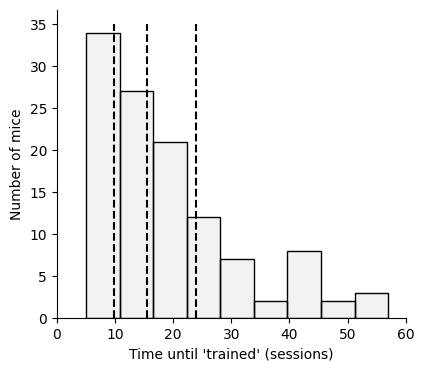

In [4]:
"""
HISTOGRAM - include all mice used to calculate quartiles
"""

plt.figure(figsize=[4.5, 4])
plt.xlabel("Time until 'trained' (sessions)")
plt.ylabel("Number of mice")
plt.xlim([0,60])
plt.rc('font', size=12)
sns.despine(top=True, right=True)
points = sns.histplot(list(mat['training_time'].dropna()), kde=False, color='black', edgecolor='k', alpha=0.05, linewidth=1) 
plt.vlines(quantiles[0.25], 0, 35, colors='k', linestyles='dashed')
plt.vlines(quantiles[0.5], 0, 35, colors='k', linestyles='dashed')
plt.vlines(quantiles[0.75], 0, 35, colors='k', linestyles='dashed')
plt.savefig('histogram.svg',dpi=500)


In [5]:
# --Remove NaNs and mouse column from design matrix

mat = mat.drop(columns=['subject_nickname', 'subject_uuid', 'training_time'])
mat1 = mat.copy() # Full classifier
mat2 = mat1[['perf_delta1', var]] # Performance change classifier; get matrix from mat1, to make sure the same mice are included

In [6]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice

shufflings = 100  #shuffling
repetitions = 10  # permutation repetitions
model = RandomForestClassifier(random_state=0)
matrices = [mat1, mat2]

# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

for m, mt in enumerate(matrices):

    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    use_mat = matrices[m].copy() # test using all mice

    # -- ORIGINAL DATASET
    
    dec_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

    y_pred = np.zeros(len(use_mat), dtype=int) 
    exog = use_mat[use_mat.columns.difference([var])]
    endog = use_mat.loc[:, var]

    for train_index, test_index in kf.split(use_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')
    
    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'matrix'] = m
    dec_result.loc[0, 'shuffle'] = 0

    decoding_result = pd.concat([decoding_result, dec_result])
    
    # -- DETERMINE FEATURE IMPORTANCE BY PERMUTING FEATURE VALUES
    
    
    # Only for the full model 
    if m == 0:
        features = exog.keys() 
        permutation_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
            
        # Score of original non-cross-validated model    
        original_model = model.fit(exog, endog.astype(int))
        original_pred = np.zeros(len(exog), dtype=int) 
        original_pred = model.predict(exog)
        original_f1 = f1_score(endog.astype(int), original_pred.astype('int'), average='micro')

        # Loop over each feature 
        for f, feature in enumerate(features):
        
            # Permute each feature several times
            perm_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
            for n in range(repetitions):
            
                permuted_exog = exog.copy()
                permuted_exog[features[f]] = np.random.permutation(permuted_exog[features[f]].values)
                
                #  Fit model and make predictions
                model.fit(exog, endog.astype(int))
                permuted_y_pred = np.zeros(len(exog), dtype=int)
                permuted_y_pred = model.predict(permuted_exog)
                
                # Calculate f1 score for model with permuted feature
                permuted_f1 = f1_score(endog.astype(int), permuted_y_pred.astype('int'), average='micro')

                # Save results
                perm_result.loc[n, 'repetition'] = n
                perm_result.loc[n, 'feature'] = features[f]
                perm_result.loc[n, 'f1'] = permuted_f1
            
            permutation_result = pd.concat([permutation_result, perm_result])
    
    # -- SHUFFLED DATASET 

    shuffle_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(use_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(use_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'matrix'] = m
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])

Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100


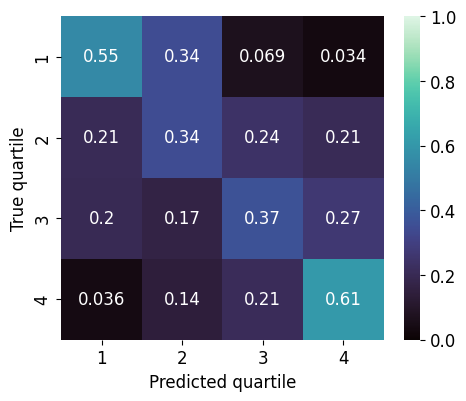

F1 results 0.46551724137931033


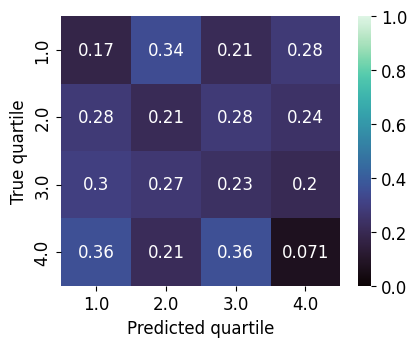

F1 shuffled results 0.1724137931034483


In [10]:
"""
PLOT RESULTS
"""

# -- Confusion Matrix
labels = np.array(mat[var])

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[5.2, 4.2])
hmap = sns.color_palette("mako", as_cmap=True)
data = decoding_result.loc[(decoding_result['matrix'] == 0) & (decoding_result['shuffle'] == 0)]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels.astype(int)), xticklabels=np.unique(labels.astype(int)), 
    cmap= hmap, vmin=0, vmax=1) 
plt.xlabel('Predicted quartile')
plt.ylabel('True quartile')
plt.savefig('full_cm.svg',dpi=500)
plt.show()
print('F1 results', data['f1'].mean())


# Results from shuffled model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
data = decoding_result.loc[(decoding_result['matrix'] == 0) & (decoding_result['shuffle'] == 1)]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels), xticklabels=np.unique(labels), 
    cmap= hmap, vmin=0, vmax=1)
plt.xlabel('Predicted quartile')
plt.ylabel('True quartile')
plt.show()
print('F1 shuffled results',  data['f1'].mean())



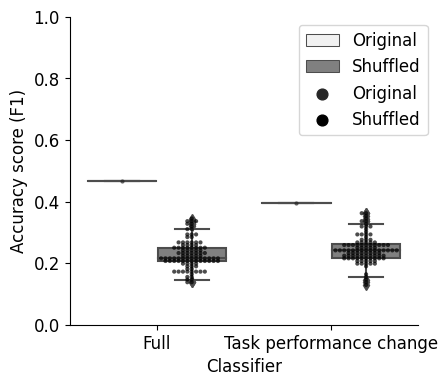

In [11]:
# -- F1 score per model, original and shuffled
data = decoding_result.copy()
data['f1'] = data['f1'].astype(float)
data.loc[data['matrix'] == 0, 'matrix'] = 'Full'
data.loc[data['matrix'] == 1, 'matrix'] = 'Task performance change'
data = data.rename(columns={'matrix': 'Classifier'})

data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
data = data.rename(columns={'shuffle': 'Dataset'})

plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 4])
sns.boxplot(hue='Dataset', y='f1', x='Classifier', data=data, color='grey') 
sns.swarmplot(y='f1', x='Classifier', data=data, color='black', hue='Dataset', dodge=True, alpha=0.7, size=3)
plt.ylim([0,1])
plt.ylabel('Accuracy score (F1)')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(top=True, right=True)
plt.savefig('violin.svg',dpi=500)

/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


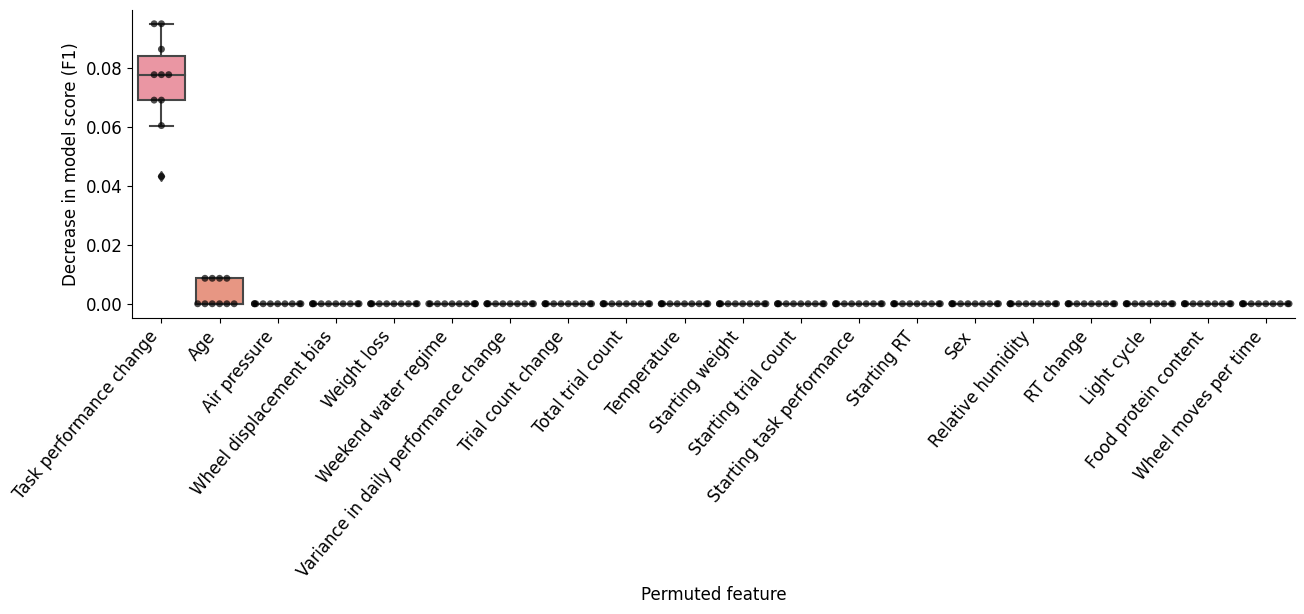

In [12]:
# -- Permutation tests for full model
f1_full_model = decoding_result.loc[(decoding_result['matrix']==0) & (decoding_result['shuffle']==0), 'f1'][0]
data = permutation_result.copy()
data['f1'] = data['f1'].astype(float)
data['f1'] = original_f1 - data['f1']
data = data.replace(['RT_delta1', 'RT_init', 'age_start', 'air_pressure_mb', 
    'delta_variance', 'disp_norm', 'moves_time',
    'perf_init', 'relative_humidity', 'sex', 
    'temperature_c', 'trials_delta1', 'trials_init', 'trials_sum', 
    'water_weight', 'weekend_water', 'weight_loss', 'light', 'food',
    'weight_start', 'perf_delta1'], ['RT change', 'Starting RT',
    'Age', 'Air pressure', 'Variance in daily performance change', 
    'Wheel displacement bias', 'Wheel moves per time',
    'Starting task performance', 'Relative humidity', 'Sex', 'Temperature', 
    'Trial count change', 'Starting trial count', 'Total trial count',
    'Consumed water per body weight', 'Weekend water regime', 
    'Weight loss', 'Light cycle', 'Food protein content',
    'Starting weight', 'Task performance change'])

plot_order = data.groupby('feature')['f1'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.boxplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v') 
sns.swarmplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v', color='black', alpha=0.7) 
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)
sns.despine(top=True, right=True)
plt.savefig('permutation_importances.svg',dpi=500)
